# #6. Models 

0. [Motivation](#Motivation)
1. [ORM](#ORM)
    1. [Models](#Models)
    1. [CRUD](#CRUD)
    2. [N+1 problem](#N+1-problem)
    3. [Object managers](#Object-managers)
    4. [Raw](#Raw)
    5. [LIMIT](#LIMIT)
    6. [IN](#IN)
2. [Indexes](#Indexes)
3. [Transactions](#Transactions)
4. [Migrations](#Migrations)
5. [Backup](#Backup)
6. [Replication](#Replication)
7. [Sharding](#Sharding)
8. [NoSQL](#NoSQL)
9. [SQLAlchemy](#SQLAlchemy)

## Motivation

__Goal__

Познакомиться с основными составляющими уровня хранения, жизненным циклом данных и особенностями манипуляции ими с помощью ORM

__Homework__

Hasker!

## ORM

#### Models

* break apps with many models
    * 5 models per app preferably
* stick to fat models
    * instead of putting data-related code in views and templates use model's methods, properties, etc.
    * beware of god objects
        * use mixins and helpers (utils)
* normalize until it hurts, denormalize until it works.


__Model Inheritance__
* Abstract base classes
    * tables created only for derived classes
    * common fields in parent
    * cannot use parent abstract class

In [ ]:
from django.db import models

class CommonInfo(models.Model):
    name = models.CharField(max_length=100)
    age = models.PositiveIntegerField()

    class Meta:
        abstract = True

class Student(CommonInfo):
    home_group = models.CharField(max_length=5)

* Multi-table inheritance
    * tables created for parents and childs
    * can use parent and childs
    * can get child object from parent object
    * each query on a child table requires JOIN with ALL parent tables

In [ ]:
from django.db import models

class Place(models.Model):
    name = models.CharField(max_length=50)
    address = models.CharField(max_length=80)

class Restaurant(Place):
    serves_hot_dogs = models.BooleanField(default=False)
    serves_pizza = models.BooleanField(default=False)

* Proxy models
    * table created only for original model
    * cannot chage model behavior

In [ ]:
from django.db import models

class Person(models.Model):
    first_name = models.CharField(max_length=30)
    last_name = models.CharField(max_length=30)

class MyPerson(Person):
    class Meta:
        proxy = True

    def do_something(self):
        # ...
        pass

#### CRUD

In [ ]:
from flavors.models import Flavor
from store.exceptions import OutOfStock, CorruptedDatabase

def list_flavor_line_item(sku):
    try:
        return Flavor.objects.get(sku=sku, quantity__gt=0)
    except Flavor.DoesNotExist:
        msg = 'We are out of {}'.format(sku)
        raise OutOfStock(msg)
    except Flavor.MultipleObjectsReturned:
        msg = 'Multiple items have SKU {}. Please fix!'.format(sku)
        raise CorruptedDatabase(msg)

__Lazy evaluation__

In [ ]:
>>> my_queryset = SomeModel.objects.all()
>>> my_queryset[5].some_attribute
3
>>> my_queryset[5].some_attribute = 2
>>> my_queryset[5].save()
>>> my_queryset[5].some_attribute
3
>>> # WAT

* A performance trade-off
* Calling a QuerySet method will usually clone the pre-existing QuerySet, apply the change, and return the new instance (doing a new query)
* Except for iteration, length/existence checks, which can re-use the existing QuerySet instance’s results cache without doing a new query

In [ ]:
from django.models import Q

from promos.models import Promo

def fun_function(**kwargs):
    """Find working ice cream promo"""
    results = Promo.objects.active()
    results = results.filter(
                Q(name__startswith=name) |
                Q(description__icontains=name)
            )
    results = results.exclude(status='melted')
    results = results.select_related('flavors')
    return results

Do not evaluate query set unless you have to
* Defeats Django’s lazy-evaluation mechanism by dragging everything into memory.
* Does filtration or summarization in the application that is much more efficiently done in the database

In [ ]:
# ~2,500,000 строк в таблице “Orders” (MySQL InnoDB).
qs = Orders.objects.all()
for order in qs:
    order.age_in_days += 1
    order.save()

When QuerySets are evaluated
* Iteration
    * use update(), raw(), or custom iteration helper
* Slicing
    * generally, slicing a QuerySet returns a new QuerySet – it doesn’t evaluate the query
    * exception is if you use the “step” parameter of Python slice syntax
* repr()
* len()
    * use count()
* list()
* bool(), or, and, if
    * use exists()

* Once evaluated, a QuerySet holds on to its result set.
    * Reuse the same result set whenever possible!
* Remember that each filter you apply to a QuerySet creates a new query set.
    * That time can add up.
    * It can be faster to drop to raw SQL for super-complex queries.
* Don’t retrieve things you don’t need
    * use values() and values_list()
    * use defer() and only()

In [ ]:
>>> entry = Entry.objects.get(id=1)
>>> entry.blog   # Blog object is retrieved at this point
>>> entry.blog   # cached version, no DB access

In [ ]:
# in general, callable attributes cause DB lookups every time
>>> entry = Entry.objects.get(id=1)
>>> entry.authors.all()   # query performed
>>> entry.authors.all()   # query performed again

__Query expressions__

In [ ]:
from django.db.models import F

from models.customers import Customer

customers = Customer.objects.filter(scoops_ordered__gt=F('store_visits'))
# SELECT * from customers_customer where scoops_ordered > store_visits

#### N+1 problem

In [ ]:
from django.db import models

class Topping(models.Model):
    name = models.CharField(max_length=30)

class Pizza(models.Model):
    name = models.CharField(max_length=50)
    toppings = models.ManyToManyField(Topping)

    def __str__(self):
        return "%s (%s)" % (
            self.name,
            ", ".join(topping.name for topping in self.toppings.all()),
        )

class Restaurant(models.Model):
    pizzas = models.ManyToManyField(Pizza, related_name='restaurants')
    best_pizza = models.ForeignKey(Pizza)

In [ ]:
>>> Pizza.objects.all()
["Hawaiian (ham, pineapple)", "Seafood (prawns, smoked salmon)"...

select_related
* used for foreign keys and one-to-one realtions
* results in a single more complex query with JOIN

In [ ]:
>>> Restaurant.objects.select_related('best_pizza')

prefetch_related
* used for many-to-many, many-to-one realtions
* does a separate lookup for each relationship
* does the ‘joining’ in Python
* object loaded in QuerySet cache (not lazy)
* in most cases will be implemented using an SQL query that uses the ‘IN’ operator

In [ ]:
# One extra query to select all toppings and put them in a QuerySet cache
>>> Pizza.objects.all().prefetch_related('toppings')
 
>>> pizzas = Pizza.objects.prefetch_related('toppings')
# Cache is cleared, previous prefetch won't help
>>> [list(pizza.toppings.filter(spicy=True)) for pizza in pizzas]

# total 3 quries
>>> Restaurant.objects.prefetch_related('pizzas__toppings')

#### Object managers

In [ ]:
from django.db import models
from django.utils import timezone

class PublishedManager(models.Manager):

    use_for_related_fields = True

    def published(self, **kwargs):
        return self.filter(pub_date__lte=timezone.now(), **kwargs)

class FlavorReview(models.Model):
    review = models.CharField(max_length=255)
    pub_date = models.DateTimeField()

    # add our custom model manager
    objects = PublishedManager()

In [ ]:
>>> from reviews.models import FlavorReview
>>> FlavorReview.objects.count()
35
>>> FlavorReview.objects.published().count()
31

Adding new object manager
* when using model inheritance children of ABC recieve their parent's manager and children of CBC do not
* first manager applied to a model class Django treats as default
    * put obejcts = models.Manager() first

In [ ]:
from django.db import models
class DahlBookManager(models.Manager):
    def get_queryset(self):
        return super(DahlBookManager, self).get_queryset().filter(author='Roald Dahl')

class Book(models.Model):
    title = models.CharField(max_length=100)
    author = models.CharField(max_length=50)
    # ...
    objects = models.Manager() # The default manager.
    dahl_objects = DahlBookManager() # The Dahl-specific manager.

* Overriding get_queryset() will affect all queries made through that manager
* Usually best to keep a vanilla manager around so you can access everything normally

New manager v.s. New Query set

In [ ]:
class LiveEntryManager(models.Manager):
    def live(self):
        return self.filter(status=self.model.LIVE_STATUS)

class Entry(models.Model):
    # ..
    objects = LiveEntryManager()

live_entries = Entry.objects.live()

In [ ]:
class EntryQuerySet(models.QuerySet):
    def live(self):
        return self.filter(status=self.model.LIVE_STATUS)

class Entry(models.Model):
    # ..
    objects = EntryQuerySet.as_manager()

live_in_april = Entry.objects.filter(pub_date__year=2015, pub_date__month=4).live()

#### Raw

In [ ]:
from django.db import connection
def my_custom_sql(self):
    cursor = connection.cursor()
    cursor.execute("UPDATE bar SET foo = 1 WHERE baz = %s", [self.baz])
    cursor.execute("SELECT foo FROM bar WHERE baz = %s", [self.baz])
    row = cursor.fetchone()
    return row

In [ ]:
>>> for p in Person.objects.raw('SELECT id, first_name FROM myapp_person'):
    ...     print(p.first_name, # This will be retrieved by the original query
    ...           p.last_name) # This will be retrieved on demand
    ...
John Smith
Jane Jones

#### LIMIT

* qs[:x] adds a LIMIT clause to the SQL.
* Remember that LIMIT isn’t really useful without a sort.
    * database has to sort the entire result set before applying the LIMIT.
* an index on the sort key is a good idea
* qs[x:y] does an OFFSET x LIMIT y-x.
* OFFSET has to consider and toss every object from 1 to x-1.
* Very large OFFSETs are extremely inefficient.
* Much better to use queries on indexed columns instead.
* For pagination, consider strongly limiting how deep it can go.

#### IN

In [ ]:
Thing.objects.filter(id__in=my_little_list)

In [ ]:
 SELECT ""stuff_thing"".""id"", ""stuff_thing"".""thing1"", ""stuff_thing"".""thing2"" FROM ""stuff_thing"" WHERE
    ""stuff_thing"".""id"" IN (3702, 3705, 3708, 3711, 3714, 3717, 3720, 3723, 3726, 3729, 3732, 3735, 3738, 3741, 3744, 3747, 3750,
    3753, 3756, 3759, 3762, 3765, 3768, 3771, 3774, 3777, 3780, 3783, 3786, 3789, 3792, 3795, 3798, 3801, 3804, 3807, 3810, 3813, 3816,
    3819, 3822, 3825, 3828, 3831, 3834, 3837, 3840, 3843, 3846, 3849, 3852, 3855, 3858, 3861, 3864, 3867, 3870, 3873, 3876, 3879, 3882,
    3885, 3888, 3891, 3894, 3897, 3900, 3903, 3906, 3909, 3912, 3915, 3918, 3921, 3924, 3927, 3930, 3933, 3936, 3939, 3942, 3945, 3948,
    3951, 3954, 3957, 3960, 3963, 3966, 3969, 3972, 3975, 3978, 3981, 3984, 3987, 3990, 3993, 3996, 3999, 4002, 4005, 4008, 4011, 4014,
    4017, 4020, 4023, 4026, 4029, 4032, 4035, 4038, 4041, 4044, 4047, 4050, 4053, 4056, 4059, 4062, 4065, 4068, 4071, 4074, 4077, 4080,
    4083, 4086, 4089, 4092, 4095, 4098, 4101, 4104, 4107, 4110, 4113, 4116, 4119, 4122, 4125, 4128, 4131, 4134, 4137, 4140, 4143, 4146,
    4149, 4152, 4155, 4158, 4161, 4164, 4167, 4170, 4173, 4176, 4179, 4182, 4185, 4188, 4191, 4194, 4197, 4200, 4203, 4206, 4209, 4212,
    4215, 4218, 4221, 4224, 4227, 4230, 4233, 4236, 4239, 4242, 4245, 4248, 4251, 4254, 4257, 4260, 4263, 4266, 4269, 4272, 4275, 4278,
    4281, 4284, 4287, 4290, 4293, 4296, 4299, 4302, 4305, 4308, 4311, 4314, 4317, 4320, 4323, 4326, 4329, 4332, 4335, 4338, 4341, 4344,
    4347, 4350, 4353, 4356, 4359, 4362, 4365, 4368, 4371, 4374, 4377, 4380, 4383, 4386, 4389, 4392, 4395, 4398, 4401, 4404, 4407, 4410,
    4413, 4416, 4419, 4422, 4425, 4428, 4431, 4434, 4437, 4440, 4443, 4446, 4449, 4452, 4455, 4458, 4461, 4464, 4467, 4470, 4473, 4476,
    4479, 4482, 4485, 4488, 4491, 4494, 4497, 4500, 4503, 4506, 4509, 4512, 4515, 4518, 4521, 4524, 4527, 4530, 4533, 4536, 4539, 4542,
    4545, 4548, 4551, 4554, 4557, 4560, 4563, 4566, 4569, 4572, 4575, 4578, 4581, 4584, 4587, 4590, 4593, 4596, 4599, 4602, 4605, 4608,
    4611, 4614, 4617, 4620, 4623, 4626, 4629, 4632, 4635, 4638, 4641, 4644, 4647, 4650, 4653, 4656, 4659, 4662, 4665, 4668, 4671, 4674,
    4677, 4680, 4683, 4686, 4689, 4692, 4695, 4698, 4701, 4704, 4707, 4710, 4713, 4716, 4719, 4722, 4725, 4728, 4731, 4734, 4737, 4740,
    4743, 4746, 4749, 4752, 4755, 4758, 4761, 4764, 4767, 4770, 4773, 4776, 4779, 4782, 4785, 4788, 4791, 4794, 4797, 4800, 4803, 4806,
    4809, 4812, 4815, 4818, 4821, 4824, 4827, 4830, 4833, 4836, 4839, 4842, 4845, 4848, 4851, 4854, 4857, 4860, 4863, 4866, 4869, 4872,
    4875, 4878, 4881, 4884, 4887, 4890, 4893, 4896, 4899, 4902, 4905, 4908, 4911, 4914, 4917, 4920, 4923, 4926, 4929, 4932, 4935, 4938,
    4941, 4944, 4947, 4950, 4953, 4956, 4959, 4962, 4965, 4968, 4971, 4974, 4977, 4980, 4983, 4986, 4989, 4992, 4995, 4998, 5001, 5004,
    5007, 5010, 5013, 5016, 5019, 5022, 5025, 5028, 5031, 5034, 5037, 5040, 5043, 5046, 5049, 5052, 5055, 5058, 5061, 5064, 5067, 5070,
    5073, 5076, 5079, 5082, 5085, 5088, 5091, 5094, 5097, 5100, 5103, 5106, 5109, 5112, 5115, 5118, 5121, 5124, 5127, 5130, 5133, 5136,
    5139, 5142, 5145, 5148, 5151, 5154, 5157, 5160, 5163, 5166, 5169, 5172, 5175, 5178, 5181, 5184, 5187, 5190, 5193, 5196, 5199, 5202,
    5205, 5208, 5211, 5214, 5217, 5220, 5223, 5226, 5229, 5232, 5235, 5238, 5241, 5244, 5247, 5250, 5253, 5256, 5259, 5262, 5265, 5268,
    5271, 5274, 5277, 5280, 5283, 5286, 5289, 5292, 5295, 5298, 5301, 5304, 5307, 5310, 5313, 5316, 5319, 5322, 5325, 5328, 5331, 5334,
    5337, 5340, 5343, 5346, 5349, 5352, 5355, 5358, 5361, 5364, 5367, 5370, 5373, 5376, 5379, 5382, 5385, 5388, 5391, 5394, 5397, 5400,
    5403, 5406, 5409, 5412, 5415, 5418, 5421, 5424, 5427, 5430, 5433, 5436, 5439, 5442, 5445, 5448, 5451, 5454, 5457, 5460, 5463, 5466,
    5469, 5472, 5475, 5478, 5481, 5484, 5487, 5490, 5493, 5496, 5499, 5502, 5505, 5508, 5511, 5514, 5517, 5520, 5523, 5526, 5529, 5532,
    5535, 5538, 5541, 5544, 5547, 5550, 5553, 5556, 5559, 5562, 5565, 5568, 5571, 5574, 5577, 5580, 5583, 5586, 5589, 5592, 5595, 5598,
    5601, 5604, 5607, 5610, 5613, 5616, 5619, 5622, 5625, 5628, 5631, 5634, 5637, 5640, 5643, 5646, 5649, 5652, 5655, 5658, 5661, 5664,
    5667, 5670, 5673, 5676, 5679, 5682, 5685, 5688, 5691, 5694, 5697, 5700, 5703, 5706, 5709, 5712, 5715, 5718, 5721, 5724, 5727, 5730,
    5733, 5736, 5739, 5742, 5745, 5748, 5751, 5754, 5757, 5760, 5763, 5766, 5769, 5772, 5775, 5778, 5781, 5784, 5787, 5790, 5793, 5796,
    5799, 5802, 5805, 5808, 5811, 5814, 5817, 5820, 5823, 5826, 5829, 5832, 5835, 5838, 5841, 5844, 5847, 5850, 5853, 5856, 5859, 5862,
    5865, 5868, 5871, 5874, 5877, 5880, 5883, 5886, 5889, 5892, 5895, 5898, 5901, 5904, 5907, 5910, 5913, 5916, 5919, 5922, 5925, 5928,

* large IN's are bad
* Very expensive for the database to parse
* Very expensive for the database to execute.
* If there are potentially more than 10-15 items in the list, rework the IN as a JOIN against whatever the source of the keys is.

### References

* https://www.youtube.com/playlist?list=PLrCZzMib1e9r6c-j8aW1JuETSyCBp9iAg
* https://lukeplant.me.uk/blog/posts/avoid-django-genericforeignkey/
* https://docs.djangoproject.com/en/1.11/topics/db/optimization/
* http://blog.kevinastone.com/django-model-behaviors.html
* https://medium.com/eshares-blog/supercharging-django-productivity-at-eshares-8dbf9042825e
* http://www.bedjango.com/blog/Django-model-managers/

### Summary

* think like a database! be a database!
* models are foundation of Dango project, design them thoughtfully
* start normalized, denormalize only if nothing else helps
    * rewrite quries
    * raw
    * caching
* dont forget about indexes
* inherit from ABC if you gonna use inheritance at all
* be carefull with null=True and blank=True

## Indexes

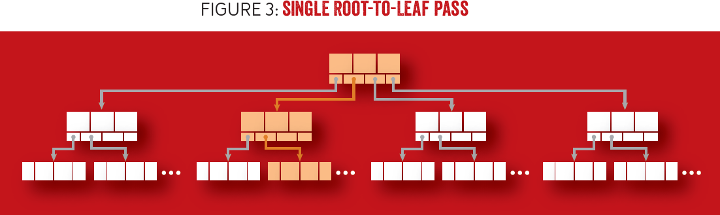

Good index
* Higly selective
    * Greatly reduces the number of candidate rows when used.
* Used very regularly by the application code. 
* Or required to enforce constraints.

Bad index
* Every other index.
* Bad selectivity.
* Rarely used.
* Expense to maintain compared to the acceleration of queries that use it.
* An unselective index is more expensive than a sequential scan.

Example indexing strategy
* Start with none (except those required by keys or constraints).
* Analyze the queries and look for ones which
    * query a constant column or set of columns AND
    * select <10%...25% of the rows in the target table.

Multi-column indexes
* single compound index
    * smaller 
    * faster
    * specific
* miltiple indexes
    * more general

### References

* http://coding-geek.com/how-databases-work/
* https://cstack.github.io/db_tutorial/
* https://www.youtube.com/watch?v=e1wbQPbFZdk
* https://queue.acm.org/detail.cfm?id=3220266
* https://blog.acolyer.org/2018/06/28/how-_not_-to-structure-your-database-backed-web-applications-a-study-of-performance-bugs-in-the-wild/
* https://begriffs.com/posts/2018-01-01-sql-keys-in-depth.html
* http://use-the-index-luke.com/
* https://mariadb.com/kb/en/library/building-the-best-index-for-a-given-select/

### Summary

* Use index, Luke!
* indexes have costs
* measure first

## Transactions

Django’s default behavior is to run in autocommit mode

Atomic
* commits on success
* rollsback on Exception

In [ ]:
from django.db import IntegrityError, transaction

@transaction.atomic
def viewfunc(request):
    create_parent()

    try:
        with transaction.atomic():
            generate_relationships()
    except IntegrityError:
        handle_exception()

    add_children()

Under the hood, Django’s transaction management code:
* opens a transaction when entering the outermost atomic block
* creates a savepoint when entering an inner atomic block
* releases or rolls back to the savepoint when exiting an inner block
* commits or rolls back the transaction when exiting the outermost block

__Locking__

* Readers do not block readers to the same row (it would be kind of dopey if they did).
* Writers do not block readers; they create a new version of the row.
* Readers do not block writers; they read the old version of the row.
* Writers, however, do block writers.
* There are a whole ton of different kinds of table locks.
    * interesting for our purposes is the exclusive row lock.
    * automatically acquired when a process updates or deletes a row.
    * no other process can update or delete that row until the first process commit
* Locks are only held for the duration of a transaction.
* Once the transaction either commits or rolls back, the lock is released.
* So: Keep transactions as fast as possible.
* Long-running, database-modifying transactions are the source of most serious concurrency problems.

### References

* http://www.bailis.org/blog/when-is-acid-acid-rarely/
* https://docs.djangoproject.com/en/1.11/topics/db/transactions/

### Summary

* transactions have costs, use them when necessary
* use atomic context manager and decorator
* check database transaction isolation level


## Migrations

Migrations like version control system for your database schema
* `makemigrations` is responsible for packaging up your model changes into individual migration files - analogous to commits
* `migrate` is responsible for applying those to your database.

Migrations workflow
* change models
* run and inspect output of `makemigrations` at dev enviroment
* add special operations of needed
    * `RunSQL`: allows you to pass in raw SQL and execute it as part of your model.
    * `RunPython`: passes in a callable to be executed
        * useful for things like data loading as part of the migration.
* check by running `migrate` at dev enviroment
* commit migration files and code
* run migrate at production

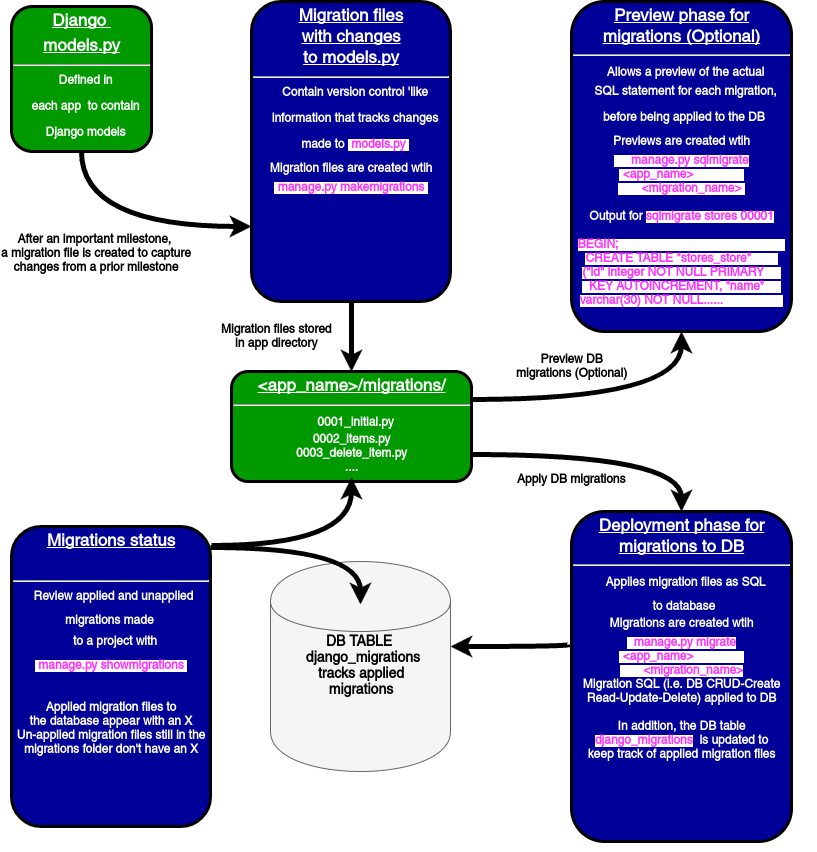

Schema migration

In [ ]:
from django.db import migrations, models

class Migration(migrations.Migration):

    dependencies = [('migrations', '0001_initial')]

    operations = [
        migrations.DeleteModel('Tribble'),
        migrations.AddField('Author', 'rating', models.IntegerField(default=0)),
    ]

Data migration

In [ ]:
from django.db import migrations, models

def add_cones(apps, schema_editor):
    Scoop = apps.get_model('scoop', 'Scoop')
    Cone = apps.get_model('cone', 'Cone')

    for scoop in Scoop.objects.all():
        Cone.objects.create(
            scoop=scoop,
            style='sugar'
        )

class Migration(migrations.Migration):

    initial = True

    dependencies = [
        ('scoop', '0051_auto_20670724'),
    ]

    operations = [
        migrations.CreateModel(
            name='Cone',
            fields=[
                ('id', models.AutoField(auto_created=True, primary_key=True,
                    serialize=False, verbose_name='ID')),
                ('style', models.CharField(max_length=10),
                    choices=[('sugar', 'Sugar'), ('waffle', 'Waffle')]),
                ('scoop', models.OneToOneField(null=True, to='scoop.Scoop'
                    on_delete=django.db.models.deletion.SET_NULL, )),
            ],
        ),
        # RunPython.noop does nothing but allows reverse migrations to occur
        migrations.RunPython(add_cones, migrations.RunPython.noop)
    ]

__Warning__:
* `RunPython` works with historical version of your models, so you will NOT have custom `save()` methods called on objects when you access them in migrations, and you will NOT have any custom constructors or instance methods. Plan appropriately!
* You can optionally serialize managers into migrations and have them available in RunPython operations. This is done by defining a `use_in_migrations` attribute on the manager class

__Deployment__
* backup your data before running migration
    * especially for MySQL that doesn't suppout transactional DDL
* before deployment check that you can rollback migration
* migrations on large tables can take alot of time
    * triggers + rename
    * slave swap
    *  third-party tools

### References

* https://docs.djangoproject.com/en/1.11/topics/migrations/
* https://speakerdeck.com/nduthoit/the-path-to-smoother-database-migrations
* http://www.brunton-spall.co.uk/post/2014/05/06/database-migrations-done-right/

### Summary

* as soon as new app created take extra minute to create initial migration
* examine generated mgration code
* squashmigrations if there too many of them
* backup data before migration

## Backup

__Types__
* Full
* Incremental

__Period__

Detemined by volume and importancy of data
* daily
* weekly
* monthly

__Store__
* indefinetly
* standalone dedicated server at other DC
    * not ftp
    * not Dropbox
    * not on the same server

__Tools__

* mysqldump
* percona_xtrabackup
* pg_dump
* lvm snapshot

### References

* https://about.gitlab.com/2017/02/10/postmortem-of-database-outage-of-january-31/
* http://www.tldp.org/HOWTO/LVM-HOWTO/snapshots_backup.html
* https://www.youtube.com/watch?v=FJcrmnrBiTg

### Summary

* backup every bit of important data
* replication is not a backup!
* monitor and verify your backups

## Replication

Changes translation between DBs

__Types__
* master-slave, master-master
* sync, async
* push, pull

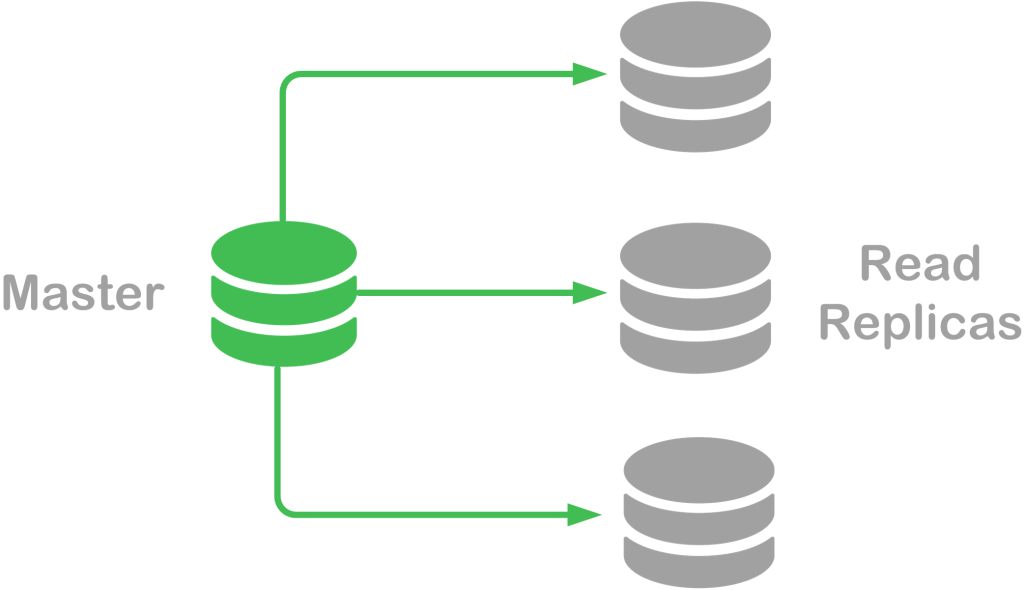

__For__
* read load distribution
* high availability
* dev processes

### References

* https://www.youtube.com/watch?v=jL985VczwC8
* http://shop.oreilly.com/product/0636920022343.do
* http://www.25hoursaday.com/weblog/2009/01/16/BuildingScalableDatabasesProsAndConsOfVariousDatabaseShardingSchemes.aspx

### Summary

* replication is not a backup!
* (almost) every databse should be replicated for fault tolerance reasons
* choose settings wisely, don't use defaults
* know how replication works

## Sharding

Allows to distribute write load and horizontally scale storage

__Key__
* easily divisible
* high/know degree of randomness
* targets a single shard

__Types__
* pre-sharding
* modulo
* hash
* table function
* consistent hashing

__Routing__
* smart client
* coordinator
* proxy
    * global
    * per-server

In [ ]:
DEFAULT_CONFIG = {
  "OK_PROFILES_MEMSRV": {
      1: '127.0.0.1:2001',
  },
  "OK_PROFILES_MEMMAP": [
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
  ],
}
# skipped code
server = config["OK_PROFILES_MEMSRV"][config["OK_PROFILES_MEMMAP"][int(row['customer_id']) % len(config["OK_PROFILES_MEMMAP"])]]

### References

* http://www.highload.ru/2015/abstracts/1550.html
* https://www.youtube.com/watch?v=MhGO7BBqSBU
* http://oldblog.antirez.com/post/redis-presharding.html
* https://docs.mongodb.com/manual/sharding/
* https://akshatm.svbtle.com/consistent-hash-rings-theory-and-implementation

### Summary

* remember: premature optimization is the root of all evil
* choose key wisely
    * painful to change later on
* some databases have autosharding

## NoSQL

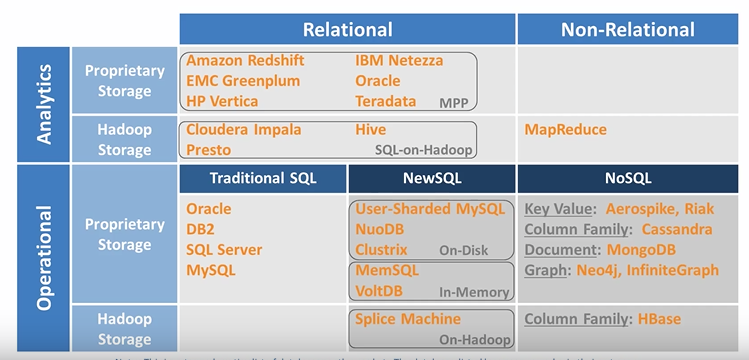

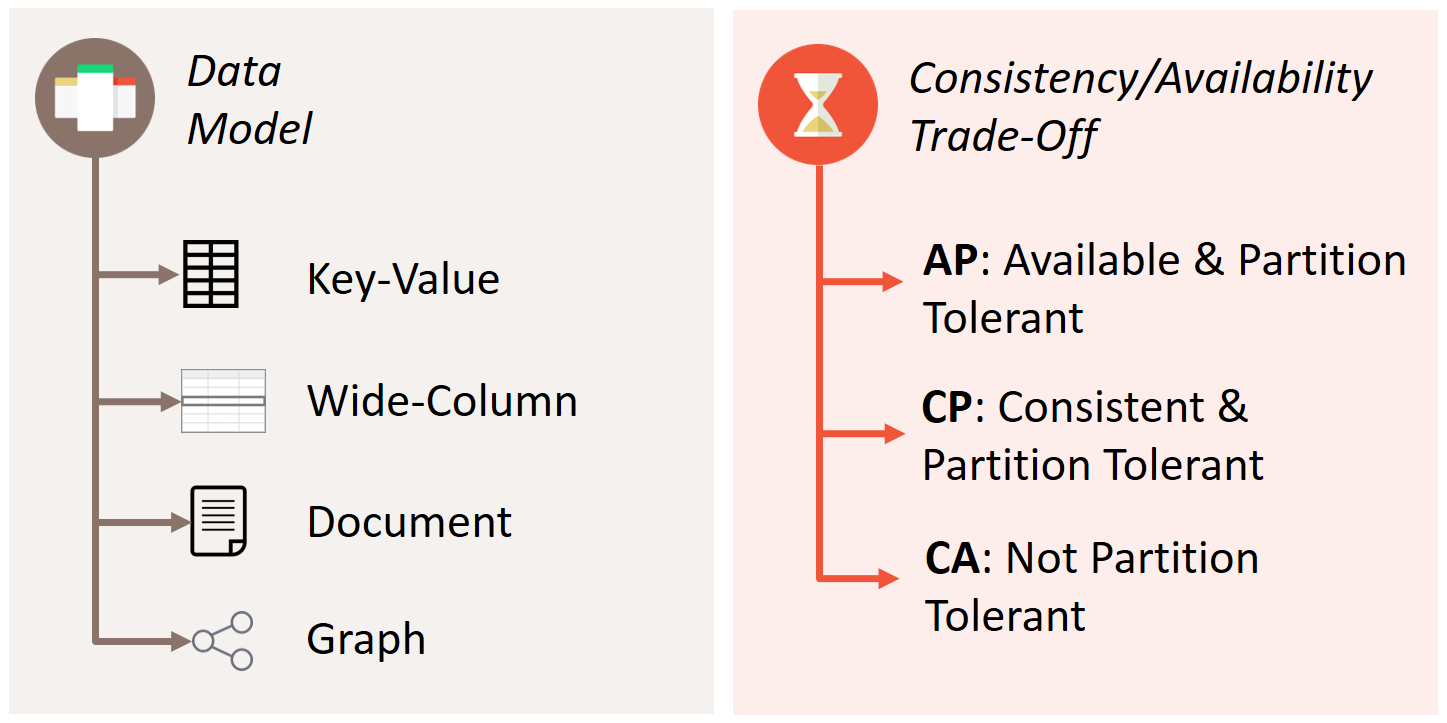

### References

* https://www.youtube.com/watch?v=RYJS-jroFRk&index=10&list=PLrCZzMib1e9oOFQbuOgjKYbRUoA8zGKnj
* http://dbmsmusings.blogspot.ru/2010/03/distinguishing-two-major-types-of_29.html
* https://medium.baqend.com/nosql-databases-a-survey-and-decision-guidance-ea7823a822d
* https://habrahabr.ru/post/265747/
* https://www.youtube.com/watch?v=lzwAJxIESNU
* https://www.youtube.com/watch?v=eSaFVX4izsQ
* https://jepsen.io/analyses/mongodb-3-4-0-rc3
* https://www.allthingsdistributed.com/2018/06/purpose-built-databases-in-aws.html

### Summary

* don't put everything in one place
* use storage that suits the data
* don't believe outsider benchamrks
* examine documentation and test thoroughly

#### SQLAlchemy

Jason Myers, Rick Copeland. Essential SQLAlchemy: Mapping Python to Databases- 2nd Edition, O'Reilly Media, 2015

http://libgen.io/book/index.php?md5=D6244909449C83F2CE430D559594CC51